# CSV - Beginner (TF2)

TensorFlow2 공식 홈페이지에 나와 있는 코드들을 수행해 보면서 빠르게 TensorFlow2를 익혀 봅니다.

https://www.tensorflow.org/tutorials/load_data/csv

##### Copyright 2019 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# 경고 메시지 출력 끄기
import warnings 
warnings.filterwarnings(action='ignore')

# 노트북 셀 표시를 브라우저 전체 폭 사용하기
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, shutil, functools
import collections, pathlib, re, string

rseed = 22
import random
random.seed(rseed)

import numpy as np
np.random.seed(rseed)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind': "{:.5f}".format})

import pandas as pd
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.5f}'.format

import tensorflow as tf
tf.random.set_seed(rseed)
tf.keras.backend.set_floatx('float32') # keras default float type 설정

import tensorflow_hub as tfhub
import tensorflow_datasets as tfds
import tensorflow_text as tftext

import kerastuner as kt

import seaborn as sns

import PIL
import PIL.Image

print(f"python ver={sys.version}")
print(f"pandas ver={pd.__version__}")
print(f"numpy ver={np.__version__}")
print(f"tensorflow ver={tf.__version__}")
print(f"tensorflow execuring eagerly={tf.executing_eagerly()}")
print(f"tensorflow GPU={'True' if tf.config.experimental.list_physical_devices('GPU') else 'False'}")
print(f"keras tuner ver={kt.__version__}")
print(f"senborn ver={sns.__version__}")
print(f"PIL ver={PIL.__version__}")

python ver=3.7.6 (default, Nov 21 2020, 22:51:13) 
[Clang 12.0.0 (clang-1200.0.32.27)]
pandas ver=1.0.5
numpy ver=1.19.5
tensorflow ver=2.4.1
tensorflow execuring eagerly=True
tensorflow GPU=False
keras tuner ver=1.0.2
senborn ver=0.10.0
PIL ver=7.1.2


## Load CSV data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/csv"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/csv.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
*

____
This tutorial provides examples of how to use CSV data with TensorFlow.

There are two main parts to this:

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

This tutorial focuses on the loading, and gives some quick examples of preprocessing. For a tutorial that focuses on the preprocessing aspect see the [preprocessing layers guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#quick_recipes) and [tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers). 


## In memory data

For any small CSV dataset the simplest way to train a TensorFlow model on it is to load it into memory as a pandas Dataframe or a NumPy array. 


A relatively simple example is the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). 

* The dataset is small. 
* All the input features are all limited-range floating point values. 

Here is how to download the data into a [Pandas `DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html):

In [3]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.43500,0.33500,0.11000,0.33400,0.13550,0.07750,0.09650,7
1,0.58500,0.45000,0.12500,0.87400,0.35450,0.20750,0.22500,6
2,0.65500,0.51000,0.16000,1.09200,0.39600,0.28250,0.37000,14
3,0.54500,0.42500,0.12500,0.76800,0.29400,0.14950,0.26000,16
4,0.54500,0.42000,0.13000,0.87900,0.37400,0.16950,0.23000,13


The dataset contains a set of measurements of [abalone](https://en.wikipedia.org/wiki/Abalone), a type of sea snail. 

![an abalone shell](https://tensorflow.org/images/abalone_shell.jpg)

 [“Abalone shell”](https://www.flickr.com/photos/thenickster/16641048623/) (by [Nicki Dugan Pogue](https://www.flickr.com/photos/thenickster/), CC BY-SA 2.0)


The nominal task for this dataset is to predict the age from the other measurements, so separate the features and labels for training:


In [23]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')
print(f"type: abalone_features={type(abalone_features)}, abalone_labels={type(abalone_labels)}\n")
print(f"dtypes: abalone_features=\n{abalone_features.dtypes}\nabalone_labels=\n{abalone_labels.dtypes}")

type: abalone_features=<class 'pandas.core.frame.DataFrame'>, abalone_labels=<class 'pandas.core.series.Series'>

dtypes: abalone_features=
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
dtype: object
abalone_labels=
int64


> 데이터가 모두 숫자형이라면, pandas dataframe 또는 numpy 형태의 데이터를 직접 모델에 input으로 넣어 학습이 가능합니다.
> 여기서는 feature 는 numpyt 로 변환하고 label 은 pandas dataframe 형태로 모델에 넣어 학습을 진행하는 예를 보여줍니다.

For this dataset you will treat all features identically. Pack the features into a single NumPy array.:

In [27]:
abalone_features = np.array(abalone_features)
print(f"type: abalone_features={type(abalone_features)}, abalone_labels={type(abalone_labels)}\n")
abalone_features

type: abalone_features=<class 'numpy.ndarray'>, abalone_labels=<class 'pandas.core.series.Series'>



array([[0.43500, 0.33500, 0.11000, ..., 0.13550, 0.07750, 0.09650],
       [0.58500, 0.45000, 0.12500, ..., 0.35450, 0.20750, 0.22500],
       [0.65500, 0.51000, 0.16000, ..., 0.39600, 0.28250, 0.37000],
       ...,
       [0.53000, 0.42000, 0.13000, ..., 0.37450, 0.16700, 0.24900],
       [0.39500, 0.31500, 0.10500, ..., 0.11850, 0.09100, 0.11950],
       [0.45000, 0.35500, 0.12000, ..., 0.11450, 0.06650, 0.16000]])

Next make a regression model predict the age. Since there is only a single input tensor, a `keras.Sequential` model is sufficient here.

In [28]:
abalone_model = tf.keras.Sequential([
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(1)
])

abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                      optimizer = tf.optimizers.Adam())

To train that model, pass the features and labels to `Model.fit`:

In [29]:
abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 567us/step - loss: 88.4131
Epoch 2/10
104/104 [==============================] - 0s 520us/step - loss: 16.5819
Epoch 3/10
104/104 [==============================] - 0s 523us/step - loss: 8.5056
Epoch 4/10
104/104 [==============================] - 0s 534us/step - loss: 7.7680
Epoch 5/10
104/104 [==============================] - 0s 510us/step - loss: 7.5117
Epoch 6/10
104/104 [==============================] - 0s 511us/step - loss: 6.8061
Epoch 7/10
104/104 [==============================] - 0s 527us/step - loss: 6.8201
Epoch 8/10
104/104 [==============================] - 0s 502us/step - loss: 6.7784
Epoch 9/10
104/104 [==============================] - 0s 511us/step - loss: 6.6292
Epoch 10/10
104/104 [==============================] - 0s 500us/step - loss: 7.1391


You have just seen the most basic way to train a model using CSV data. Next, you will learn how to apply preprocessing to normalize numeric columns.

## Basic preprocessing

It's good practice to normalize the inputs to your model. The `experimental.preprocessing` layers provide a convenient way to build this normalization into your model. 

The layer will precompute the mean and variance of each column, and use these to normalize the data.

> TF2 에서 권장하는 전처리를 모델 레이어에 포함하여 사용하는 방법을 보여줍니다.

First you create the layer:

In [30]:
normalize = tf.keras.layers.experimental.preprocessing.Normalization()

Then you use the `Normalization.adapt()` method to adapt the normalization layer to your data.

Note: Only use your training data to `.adapt()` preprocessing layers. Do not use your validation or test data.

In [37]:
normalize.adapt(abalone_features)

# adapt 로 데이터를 전처리 레이어에 적용하고 나면 해당 데이터의 정보를 레이어가 가지고 있고 이를 기반으로 모델에서 데이터가 들어오면 전처리를 해줍니다.
print(f"preprocessing stat: mean={normalize.mean.numpy()}") 

preprocessing stat: mean=[0.52269 0.40658 0.13927 0.82473 0.35770 0.18016 0.23792]


Then use the normalization layer in your model:

In [38]:
norm_abalone_model = tf.keras.Sequential([
  normalize,
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(1)
])

norm_abalone_model.compile(loss = tf.losses.MeanSquaredError(),
                           optimizer = tf.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 548us/step - loss: 101.7134
Epoch 2/10
104/104 [==============================] - 0s 520us/step - loss: 66.9957
Epoch 3/10
104/104 [==============================] - 0s 512us/step - loss: 23.7168
Epoch 4/10
104/104 [==============================] - 0s 530us/step - loss: 6.3805
Epoch 5/10
104/104 [==============================] - 0s 538us/step - loss: 4.9331
Epoch 6/10
104/104 [==============================] - 0s 510us/step - loss: 4.7040
Epoch 7/10
104/104 [==============================] - 0s 516us/step - loss: 4.7777
Epoch 8/10
104/104 [==============================] - 0s 522us/step - loss: 5.1798
Epoch 9/10
104/104 [==============================] - 0s 519us/step - loss: 4.8763
Epoch 10/10
104/104 [==============================] - 0s 521us/step - loss: 5.4119


## Mixed data types

The "Titanic" dataset contains information about the passengers on the Titanic. The nominal task on this dataset is to predict who survived. 

![The Titanic](https://www.tensorflow.org/tutorials/load_data/images/csv/Titanic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:RMS_Titanic_3.jpg)

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model. 


In [40]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.00000,1,0,7.25000,Third,unknown,Southampton,n
1,1,female,38.00000,1,0,71.28330,First,C,Cherbourg,n
2,1,female,26.00000,0,0,7.92500,Third,unknown,Southampton,y
3,1,female,35.00000,1,0,53.10000,First,C,Southampton,n
4,0,male,28.00000,0,0,8.45830,Third,unknown,Queenstown,y


> 데이터가 모두 숫자 형태인 경우는 간단하게 학습이 가능하지만 문자열(또는 Object)이 섞여 있을 경우 혼합된 데이터에 대한 전처리를 모델에서 지원하기 위해 난이도 있는 전처리 레이어를 작성해야 합니다.

In [42]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

print(f"dtypes: titanic_features=\n{titanic_features.dtypes}\ntitanic_labels=\n{titanic_labels.dtypes}")

dtypes: titanic_features=
sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object
titanic_labels=
int64


Because of the different data types and ranges you can't simply stack the features into  NumPy array and pass it to a `keras.Sequential` model. Each column needs to be handled individually. 

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The `experimental.preprocessing` layers avoid this problem because they're part of the model.


In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional.ipynb). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build representation of the calculation, that you can run later. Here's a quick example:

In [43]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Do a calculation using is
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [44]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [45]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `keras.Input` objects, matching the names and data-types of the CSV columns.

In [46]:
inputs = {}

for name, column in titanic_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [47]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}
print(f"numeric_inputs: {numeric_inputs}")

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

print(f"all_numeric_inputs: {all_numeric_inputs}")

numeric_inputs: {'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>, 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>, 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>, 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>}
all_numeric_inputs: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")


Collect all the symbolic preprocessing results, to concatenate them later.

In [48]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `preprocessing.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `preprocessing.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model. 

The default settings for the `preprocessing.CategoryEncoding` layer create a one-hot vector for each input. A `layers.Embedding` would also work. See the [preprocessing layers guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#quick_recipes) and [tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) for more on this topic.

In [49]:
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(titanic_features[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

With the collection of `inputs` and `processed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

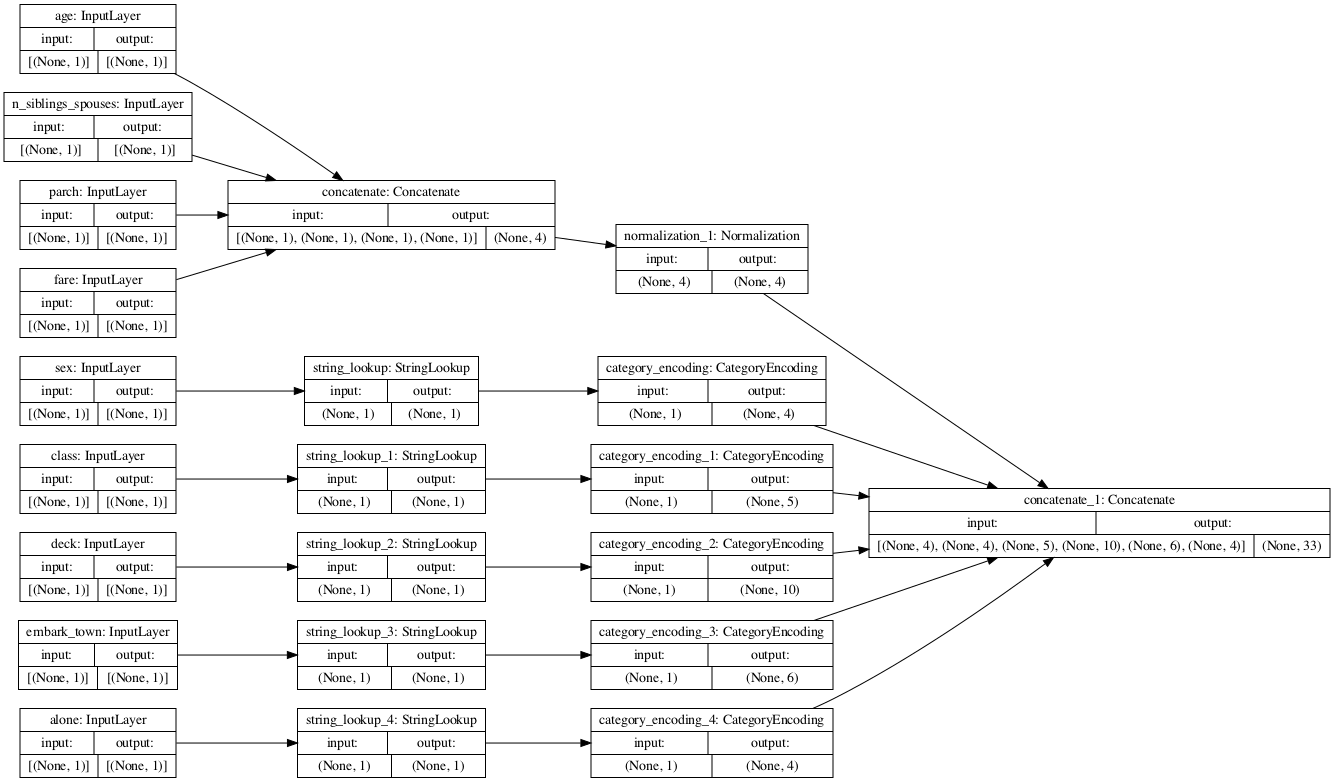

In [50]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , to_file="/tmp/model.png", rankdir="LR", dpi=72, show_shapes=True)

This `model` just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [55]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [56]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[-0.61041, 0.39520, -0.47905, -0.49740, 0.00000, 0.00000, 0.00000,
        1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000,
        0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000, 0.00000,
        0.00000, 1.00000, 0.00000, 0.00000, 0.00000, 0.00000, 1.00000,
        0.00000, 0.00000, 0.00000, 1.00000, 0.00000]], dtype=float32)>

Now build the model on top of this:

In [57]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.optimizers.Adam())
    return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [58]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 1ms/step - loss: 0.6529
Epoch 2/10
20/20 [==============================] - 0s 1ms/step - loss: 0.5334
Epoch 3/10
20/20 [==============================] - 0s 861us/step - loss: 0.4848
Epoch 4/10
20/20 [==============================] - 0s 903us/step - loss: 0.4608
Epoch 5/10
20/20 [==============================] - 0s 880us/step - loss: 0.4432
Epoch 6/10
20/20 [==============================] - 0s 917us/step - loss: 0.4100
Epoch 7/10
20/20 [==============================] - 0s 947us/step - loss: 0.4647
Epoch 8/10
20/20 [==============================] - 0s 905us/step - loss: 0.4254
Epoch 9/10
20/20 [==============================] - 0s 898us/step - loss: 0.4188
Epoch 10/10
20/20 [==============================] - 0s 928us/step - loss: 0.4680


Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [59]:
titanic_model.save('/tmp/test')
reloaded = tf.keras.models.load_model('/tmp/test')

INFO:tensorflow:Assets written to: /tmp/test/assets


In [60]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[-1.84004]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.84004]], shape=(1, 1), dtype=float32)


## Using tf.data


In the previous section you relied on the model's built-in data shuffling and batching while training the model. 

If you need more control over the input data pipeline or need to use data that doesn't easily fit into memory: use `tf.data`. 

For more examples see the [tf.data guide](../../guide/data.ipynb).

### On in memory data

As a first example of applying `tf.data` to CSV data consider the following code to manually slice up the dictionary of features from the previous section. For each index, it takes that index for each feature:


In [61]:
import itertools

def slices(features):
    for i in itertools.count():
        # For each feature take index `i`
        example = {name:values[i] for name, values in features.items()}
        yield example

Run this and print the first example:

In [62]:
for example in slices(titanic_features_dict):
    for name, value in example.items():
        print(f"{name:19s}: {value}")
    break

sex                : male
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : Third
deck               : unknown
embark_town        : Southampton
alone              : n


The most basic `tf.data.Dataset` in memory data loader is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above `slices` function, in TensorFlow. 

In [63]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

You can iterate over a `tf.data.Dataset` like any other python iterable:

In [67]:
for example in features_ds:
    for name, value in example.items():
        print(f"{name:19s}: {value}")
    break

sex                : b'male'
age                : 22.0
n_siblings_spouses : 1
parch              : 0
fare               : 7.25
class              : b'Third'
deck               : b'unknown'
embark_town        : b'Southampton'
alone              : b'n'


The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. The following code makes a dataset of `(features_dict, labels)` pairs:

In [68]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

To train a model using this `Dataset`, you'll need to at least `shuffle` and `batch` the data.

In [70]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

Instead of passing `features` and `labels` to `Model.fit`, you pass the dataset:

In [71]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
20/20 [==============================] - 0s 2ms/step - loss: 0.4207
Epoch 2/5
20/20 [==============================] - 0s 2ms/step - loss: 0.4202
Epoch 3/5
20/20 [==============================] - 0s 2ms/step - loss: 0.4199
Epoch 4/5
20/20 [==============================] - 0s 2ms/step - loss: 0.4206
Epoch 5/5
20/20 [==============================] - 0s 2ms/step - loss: 0.4203


### From a single file

So far this tutorial has worked with in-memory data. `tf.data` is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. 

In [72]:
titanic_file_path = tf.keras.utils.get_file("/tmp/train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

Now read the CSV data from the file and create a `tf.data.Dataset`. 

(For the full documentation, see `tf.data.experimental.make_csv_dataset`)


In [73]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='survived',
    num_epochs=1,
    ignore_errors=True,)

This function includes many convenient features so the data is easy to work with. This includes:

* Using the column headers as dictionary keys.
* Automatically determining the type of each column.

In [74]:
for batch, label in titanic_csv_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [28.00000 15.00000 28.00000 23.00000 31.00000]
n_siblings_spouses  : [0 1 1 0 0]
parch               : [0 1 0 0 0]
fare                : [8.05000 7.22920 24.15000 15.04580 13.00000]
class               : [b'Third' b'Third' b'Third' b'Second' b'Second']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Cherbourg' b'Queenstown' b'Cherbourg' b'Southampton']
alone               : [b'y' b'n' b'n' b'y' b'y']

label               : [0 0 0 0 1]


Note: if you run the above cell twice it will produce different results. The default settings for `make_csv_dataset` include `shuffle_buffer_size=1000`, which is more than sufficient for this small dataset, but may not be for a real-world dataset.

It can also decompress the data on the fly. Here's a gzipped CSV file containing the [metro interstate traffic dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

![A traffic jam.](https://www.tensorflow.org/tutorials/load_data/images/csv/traffic.jpg)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)


In [75]:
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='/tmp', cache_subdir='traffic')

Set the `compression_type` argument to read directly from the compressed file: 

In [76]:
traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type="GZIP")

for batch, label in traffic_volume_csv_gz_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value[:5]}")
    print()
    print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [262.42001 263.87000 292.95001 279.35999 293.28000]
rain_1h             : [0.00000 0.00000 0.00000 0.00000 0.00000]
snow_1h             : [0.00000 0.00000 0.00000 0.00000 0.00000]
clouds_all          : [ 1 40 12  1 80]
weather_main        : [b'Clear' b'Snow' b'Clouds' b'Clear' b'Rain']
weather_description : [b'sky is clear' b'heavy snow' b'few clouds' b'sky is clear' b'light rain']
date_time           : [b'2013-03-03 01:00:00' b'2012-12-30 15:00:00' b'2013-07-29 14:00:00'
 b'2013-03-29 18:00:00' b'2013-07-23 06:00:00']

label               : [ 795 3717 5356 4520 5971]


Note: If you need to parse those date-time strings in the `tf.data` pipeline you can use `tfa.text.parse_time`.

### Caching

There is some overhead to parsing the csv data. For small models this can be the bottleneck in training.

Depending on your use case it may be a good idea to use `Dataset.cache` or `data.experimental.snapshot` so that the csv data is only parsed on the first epoch. 

The main difference between the `cache` and `snapshot` methods is that `cache` files can only be used by the TensorFlow process that created them, but `snapshot` files can be read by other processes.

For example, iterating over the `traffic_volume_csv_gz_ds` 20 times, takes ~15 seconds without caching, or ~2s with caching.

In [77]:
%%time
for i, (batch, label) in enumerate(traffic_volume_csv_gz_ds.repeat(20)):
    if i % 40 == 0:
        print('.', end='')
print()

...............................................................................................
CPU times: user 10.1 s, sys: 2.35 s, total: 12.5 s
Wall time: 8.4 s


Note: `Dataset.cache`  stores the data form the first epoch and replays it in order. So using `.cache` disables any shuffles earlier in the pipeline. Below the `.shuffle` is added back in after `.cache`.

In [80]:
%%time
caching = traffic_volume_csv_gz_ds.cache().shuffle(1000)

for i, (batch, label) in enumerate(caching.shuffle(1000).repeat(20)):
    if i % 40 == 0:
        print('.', end='')
print()

...............................................................................................
CPU times: user 1.18 s, sys: 162 ms, total: 1.34 s
Wall time: 1.14 s


Note: `snapshot` files are meant for *temporary* storage of a dataset while in use. This is *not* a format for long term storage. The file format is considered an internal detail, and not guaranteed between TensorFlow versions. 

In [81]:
%%time
snapshot = tf.data.experimental.snapshot('/tmp/titanic.tfsnap')
snapshotting = traffic_volume_csv_gz_ds.apply(snapshot).shuffle(1000)

for i, (batch, label) in enumerate(snapshotting.shuffle(1000).repeat(20)):
    if i % 40 == 0:
        print('.', end='')
print()

...............................................................................................
CPU times: user 1.72 s, sys: 352 ms, total: 2.07 s
Wall time: 1.46 s


If your data loading is slowed by loading csv files, and `cache` and `snapshot` are insufficient for your use case, consider re-encoding your data into a more streamlined format.

### Multiple files

All the examples so far in this section could easily be done without `tf.data`. One place where `tf.data` can really simplify things is when dealing with collections of files.

For example, the [character font images](https://archive.ics.uci.edu/ml/datasets/Character+Font+Images) dataset is distributed as a collection of csv files, one per font.

![Fonts](https://www.tensorflow.org/tutorials/load_data/images/csv/fonts.jpg)

Image by <a href="https://pixabay.com/users/wilhei-883152/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Willi Heidelbach</a> from <a href="https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=705667">Pixabay</a>

Download the dataset, and have a look at the files inside:

In [82]:
fonts_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='/tmp', cache_subdir='fonts',
    extract=True)

In [83]:
import pathlib
font_csvs =  sorted(str(p) for p in pathlib.Path('/tmp/fonts').glob("*.csv"))

font_csvs[:10]

['/tmp/fonts/AGENCY.csv',
 '/tmp/fonts/ARIAL.csv',
 '/tmp/fonts/BAITI.csv',
 '/tmp/fonts/BANKGOTHIC.csv',
 '/tmp/fonts/BASKERVILLE.csv',
 '/tmp/fonts/BAUHAUS.csv',
 '/tmp/fonts/BELL.csv',
 '/tmp/fonts/BERLIN.csv',
 '/tmp/fonts/BERNARD.csv',
 '/tmp/fonts/BITSTREAMVERA.csv']

In [84]:
len(font_csvs)

153

When dealing with a bunch of files you can pass a glob-style `file_pattern` to the `experimental.make_csv_dataset` function. The order of the files is shuffled each iteration.

Use the `num_parallel_reads` argument to set how many files are read in parallel and interleaved together.

In [85]:
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "/tmp/fonts/*.csv",
    batch_size=10, num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000)

These csv files have the images flattened out into a single row. The column names are formatted `r{row}c{column}`. Here's the first batch:

In [86]:
for features in fonts_ds.take(1):
    for i, (name, value) in enumerate(features.items()):
        if i>15:
            break
        print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'FRANKLIN' b'FRANKLIN' b'ERAS' b'SIMPLEX' b'FRENCH' b'CURLZ' b'MISTRAL'
 b'FOOTLIGHT' b'CORBEL' b'CURLZ']
fontVariant         : [b'FRANKLIN GOTHIC MEDIUM COND' b'FRANKLIN GOTHIC MEDIUM COND'
 b'ERAS MEDIUM ITC' b'SIMPLEX' b'FRENCH SCRIPT MT' b'CURLZ MT' b'MISTRAL'
 b'FOOTLIGHT MT LIGHT' b'CORBEL' b'CURLZ MT']
m_label             : [  268  1039    59   124    61   189 64258    73   926   381]
strength            : [0.40000 0.40000 0.40000 0.40000 0.40000 0.40000 0.40000 0.40000 0.40000
 0.40000]
italic              : [0 0 0 0 1 0 0 0 0 0]
orientation         : [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
m_top               : [27 39 47 29 53 44 31 35 40 33]
m_left              : [23 24 21 29 26 22 19 22 23 22]
originalH           : [58 55 40 75 16 48 67 42 44 56]
originalW           : [30 28 11  1 38 40 36 16 32 33]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c

#### Optional: Packing fields

You probably don't want to work with each pixel in separate columns like this. Before trying to use this dataset be sure to pack the pixels into an image-tensor. 

Here is code that parses the column names to build images for each example:

In [87]:
import re

def make_images(features):
    image = [None]*400
    new_feats = {}

    for name, value in features.items():
        match = re.match('r(\d+)c(\d+)', name)
        if match:
            image[int(match.group(1))*20+int(match.group(2))] = value
        else:
            new_feats[name] = value

    image = tf.stack(image, axis=0)
    image = tf.reshape(image, [20, 20, -1])
    new_feats['image'] = image

    return new_feats

Apply that function to each batch in the dataset:

In [88]:
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
    break

Plot the resulting images:

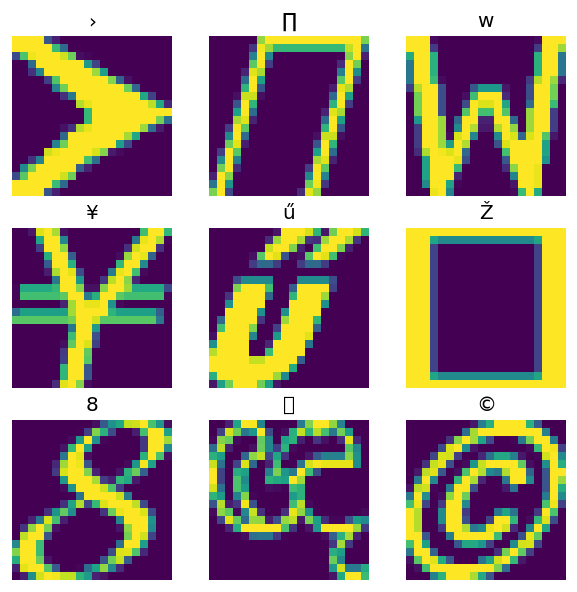

In [89]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,6), dpi=120)

for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(features['image'][..., n])
    plt.title(chr(features['m_label'][n]))
    plt.axis('off')

## Lower level functions

So far this tutorial has focused on the highest level utilities for reading csv data. There are other two APIs that may be helpful for advanced users if your use-case doesn't fit the basic patterns.

* `tf.io.decode_csv` - a function for parsing lines of text into a list of CSV column tensors.
* `tf.data.experimental.CsvDataset` - a lower level csv dataset constructor.

This section recreates functionality provided by `make_csv_dataset`, to demonstrate how this lower level functionality can be used.


### `tf.io.decode_csv`

This function decodes a string, or list of strings into a list of columns.

Unlike `make_csv_dataset` this function does not try to guess column data-types. You specify the column types by providing a list of `record_defaults` containing a value of the correct type, for each column.

To read the Titanic data **as strings** using `decode_csv` you would say: 

In [90]:
text = pathlib.Path(titanic_file_path).read_text()
lines = text.split('\n')[1:-1]

all_strings = [str()]*10
all_strings

['', '', '', '', '', '', '', '', '', '']

In [91]:
features = tf.io.decode_csv(lines, record_defaults=all_strings) 

for f in features:
    print(f"type: {f.dtype.name}, shape: {f.shape}")

type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


To parse them with their actual types, create a list of `record_defaults` of the corresponding types: 

In [92]:
print(lines[0])

0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [93]:
titanic_types = [int(), str(), float(), int(), int(), float(), str(), str(), str(), str()]
titanic_types

[0, '', 0.0, 0, 0, 0.0, '', '', '', '']

In [94]:
features = tf.io.decode_csv(lines, record_defaults=titanic_types) 

for f in features:
    print(f"type: {f.dtype.name}, shape: {f.shape}")

type: int32, shape: (627,)
type: string, shape: (627,)
type: float32, shape: (627,)
type: int32, shape: (627,)
type: int32, shape: (627,)
type: float32, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)
type: string, shape: (627,)


Note: it is more efficient to call `decode_csv` on large batches of lines than on individual lines of csv text.

### `tf.data.experimental.CsvDataset`

The `tf.data.experimental.CsvDataset` class provides a minimal CSV `Dataset` interface without the convenience features of the `make_csv_dataset` function: column header parsing, column type-inference, automatic shuffling, file interleaving.

This constructor follows uses `record_defaults` the same way as `io.parse_csv`:


In [95]:
simple_titanic = tf.data.experimental.CsvDataset(titanic_file_path, record_defaults=titanic_types, header=True)

for example in simple_titanic.take(1):
    print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


The above code is basically equivalent to:

In [96]:
def decode_titanic_line(line):
    return tf.io.decode_csv(line, titanic_types)

manual_titanic = (
    # Load the lines of text
    tf.data.TextLineDataset(titanic_file_path)
    # Skip the header row.
    .skip(1)
    # Decode the line.
    .map(decode_titanic_line)
)

for example in manual_titanic.take(1):
    print([e.numpy() for e in example])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']


#### Multiple files

To parse the fonts dataset using `experimental.CsvDataset`, you first need to determine the column types for the `record_defaults`. Start by inspecting the first row of one file: 

In [97]:
font_line = pathlib.Path(font_csvs[0]).read_text().splitlines()[1]
print(font_line)

AGENCY,AGENCY FB,64258,0.400000,0,0.000000,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,146,146,146,146,146,146,146,146,216,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,141,141,141,182,255,255,255,172,141,141,141,115,1,1,1,1,163,255,255,255,255,255,255,255,255,255,255,255,255,255,255,209,1,1,1,1,163,255,255,255,6,6,6,96,255,255,255,74,6,6,6,5,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1

Only the first two fields are strings, the rest are ints or floats, and you can get the total number of features by counting the commas:

In [98]:
num_font_features = font_line.count(',')+1
font_column_types = [str(), str()] + [float()]*(num_font_features-2)

The `CsvDatasaet` constructor can take a list of input files, but reads them sequentially. The first file in the list of CSVs is `AGENCY.csv`:

In [99]:
font_csvs[0]

'/tmp/fonts/AGENCY.csv'

So when you pass pass the list of files to `CsvDataaset` the records from `AGENCY.csv` are read first:

In [100]:
simple_font_ds = tf.data.experimental.CsvDataset(
    font_csvs, 
    record_defaults=font_column_types, 
    header=True)

In [101]:
for row in simple_font_ds.take(10):
    print(row[0].numpy())

b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'
b'AGENCY'


To interleave multiple files, use `Dataset.interleave`.

Here's an initial dataset that contains the csv file names: 

In [102]:
font_files = tf.data.Dataset.list_files("/tmp/fonts/*.csv")

This shuffles the file names each epoch:

In [103]:
print('Epoch 1:')
for f in list(font_files)[:5]:
    print("    ", f.numpy())
print('    ...')
print()

print('Epoch 2:')
for f in list(font_files)[:5]:
    print("    ", f.numpy())
print('    ...')

Epoch 1:
     b'/tmp/fonts/HARRINGTON.csv'
     b'/tmp/fonts/PALACE.csv'
     b'/tmp/fonts/HIMALAYA.csv'
     b'/tmp/fonts/BLACKADDER.csv'
     b'/tmp/fonts/PROXY.csv'
    ...

Epoch 2:
     b'/tmp/fonts/VINETA.csv'
     b'/tmp/fonts/TIMES.csv'
     b'/tmp/fonts/CONSTANTIA.csv'
     b'/tmp/fonts/RAGE.csv'
     b'/tmp/fonts/TREBUCHET.csv'
    ...


The `interleave` method takes a `map_func` that creates a child-`Dataset` for each element of the parent-`Dataset`. 

Here, you want to create a `CsvDataset` from each element of the dataset of files:

In [104]:
def make_font_csv_ds(path):
    return tf.data.experimental.CsvDataset(
        path, 
        record_defaults=font_column_types, 
        header=True)

The `Dataset` returned by interleave returns elements by cycling over a number of the child-`Dataset`s. Note, below, how the dataset cycles over `cycle_length)=3` three font files:

In [105]:
font_rows = font_files.interleave(make_font_csv_ds,
                                  cycle_length=3)

In [106]:
fonts_dict = {'font_name':[], 'character':[]}

for row in font_rows.take(10):
    fonts_dict['font_name'].append(row[0].numpy().decode())
    fonts_dict['character'].append(chr(row[2].numpy()))

pd.DataFrame(fonts_dict)

,font_name,character
0,VLADIMIR,
1,EUROROMAN,
2,E13B,0
3,VLADIMIR,
4,EUROROMAN,
5,E13B,7
6,VLADIMIR,◊
7,EUROROMAN,
8,E13B,0
9,VLADIMIR,≥


#### Performance


Earlier, it was noted that `io.decode_csv` is more efficient when run on a batch of strings.

It is possible to take advantage of this fact, when using large batch sizes, to improve CSV loading performance (but try [caching](#caching) first).

With the built-in loader 20, 2048-example batches take about 17s. 

In [107]:
BATCH_SIZE=2048
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "/tmp/fonts/*.csv",
    batch_size=BATCH_SIZE, num_epochs=1,
    num_parallel_reads=100)

In [108]:
%%time
for i,batch in enumerate(fonts_ds.take(20)):
    print('.',end='')

print()

....................
CPU times: user 20 s, sys: 1.62 s, total: 21.6 s
Wall time: 8.41 s


Passing **batches of text lines** to`decode_csv` runs faster, in about 5s:

In [109]:
fonts_files = tf.data.Dataset.list_files("/tmp/fonts/*.csv")
fonts_lines = fonts_files.interleave(
    lambda fname:tf.data.TextLineDataset(fname).skip(1), 
    cycle_length=100).batch(BATCH_SIZE)

fonts_fast = fonts_lines.map(lambda x: tf.io.decode_csv(x, record_defaults=font_column_types))

In [110]:
%%time
for i,batch in enumerate(fonts_fast.take(20)):
    print('.',end='')

print()

....................
CPU times: user 2.52 s, sys: 43.4 ms, total: 2.56 s
Wall time: 1.82 s


For another example of increasing csv performance by using large batches see the [overfit and underfit tutorial](../keras/overfit_and_underfit.ipynb).

This sort of approach may work, but consider other options like `cache` and `snapshot`, or re-enncoding your data into a more streamlined format.